In [1]:
%matplotlib widget

In [2]:
import xtrack as xt
import numpy as np
import matplotlib.pyplot as plt

### SPS model

In [3]:
env = xt.load_madx_lattice('sps.seq')
env.vars.load_madx('lhc_q20.str')
line = env.sps

# 20 GeV electrons (like in LEP times)
env.particle_ref = xt.Particles(energy0=20e9, mass0=xt.ELECTRON_MASS_EV)
line.particle_ref = env.particle_ref

# RF
line['actcse.31632'].voltage = 4.2e+08
line['actcse.31632'].frequency = 3e6
line['actcse.31632'].lag = 180.

### Build a wiggler

In [4]:
# Wiggler parameters
env['wig_length'] = 25
env['wig_num_periods'] = 20
env['wig_period_length'] = 'wig_length / wig_num_periods'
env['wig_pole_length'] = '0.25 * wig_period_length'
env['wig_k0'] = 5e-3
env['wig_tilt_rad'] = np.pi/2 # Vertical wiggler

In [5]:
# Wiggler pole
env.new('wig_pole', 'Bend',
        length='wig_pole_length',
        k0='wig_k0',
        h=0, # Straight magnet (no reference frame curvature)a
        rot_s_rad='wig_tilt_rad')

'wig_pole'

In [6]:
# Wiggler period
env.new_line(name='wig_period', components=[
    env.new('wig_pole_1', 'wig_pole', k0='-wig_k0'),
    env.new('wig_pole_2', 'wig_pole', k0='wig_k0'),
    env.new('wig_pole_3', 'wig_pole', k0='wig_k0'),
    env.new('wig_pole_4', 'wig_pole', k0='-wig_k0')])

<Line wig_period at 4427806288>

In [7]:
# Full wiggler
env['wiggler'] = env['wig_num_periods'] * env['wig_period']
env['wiggler'].replace_all_repeated_elements() # Unique name to all poles

In [8]:
%%capture
# Slice dipoles to have multiple points per pole
env['wiggler_sliced'] = env['wiggler'].copy(shallow=True)
env['wiggler_sliced'].slice_thick_elements(
    slicing_strategies=[
        xt.Strategy(slicing=xt.Teapot(10, mode='thick'))
    ])

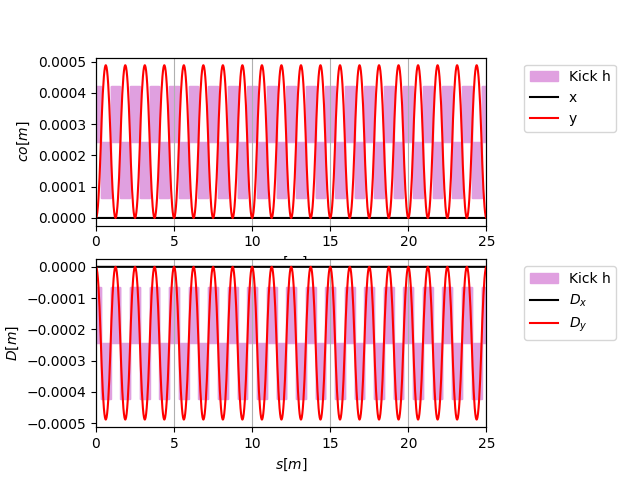

In [9]:
# Twiss to see orbit and dispersion
tw_wig = env['wiggler_sliced'].twiss(betx=1, bety=1, strengths=True)

plt.figure(figsize=(6.4, 4.8))
ax1=plt.subplot(2, 1, 1)
tw_wig.plot('x y', ax=ax1)
ax2=plt.subplot(2, 1, 2, sharex=ax1)
tw_wig.plot('dx dy', ax=ax2)
plt.subplots_adjust(right=.76, left=0.15)

### Insert the wiggler in the SPS ring

In [10]:
line.insert(env['wiggler_sliced'], anchor='start', at=1, from_='qd.31710@end')

Slicing line:   0%|          | 0/3836 [00:00<?, ?it/s]

### Enable radiation and twiss

In [11]:
line.configure_radiation('mean')
tw = line.twiss(eneloss_and_damping=True)

print(f'ex: {tw.eq_gemitt_x} ey: {tw.eq_gemitt_y}')

ex: 2.4526744554116175e-07 ey: 1.0515350672371553e-11


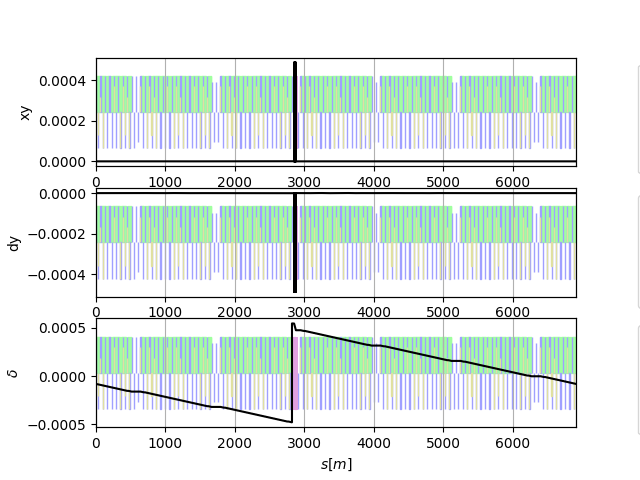

In [19]:
plt.figure()
ax0 = plt.subplot(3,1,1)
tw.plot('dx', ax=ax0)
plt.ylabel('dx')
ax1 = plt.subplot(3,1,2, sharex=ax0)
tw.plot('dy', ax=ax1)
plt.ylabel('dy')
ax2 = plt.subplot(3,1,3, sharex=ax0)
tw.plot('delta', ax=ax2)
plt.ylabel(r'$\delta$')
plt.subplots_adjust(left=.15)

(2840.0, 2890.0)

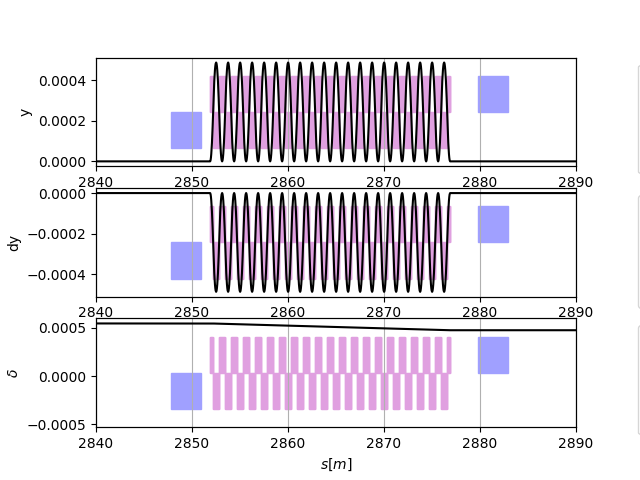

In [21]:
# Zoom on the wiggler
plt.figure(figsize=(6.4, 4.8*1.3)
ax0 = plt.subplot(3,1,1)
tw.plot('y', ax=ax0)
plt.ylabel('y')
ax1 = plt.subplot(3,1,2, sharex=ax0)
tw.plot('dy', ax=ax1)
plt.ylabel('dy')
ax2 = plt.subplot(3,1,3, sharex=ax0)
tw.plot('delta', ax=ax2)
plt.ylabel(r'$\delta$')
plt.subplots_adjust(left=.15)
plt.xlim(2840, 2890)